<a href="https://colab.research.google.com/github/RxnAch/DeepLearning/blob/main/Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U d2l

In [2]:
import torch 
from torch import nn
from d2l import torch as d2l

**DropOut in practice**

When we apply dropout to a hidden layer, zeroing out each hidden unit with probability  p , the result can be viewed as a network containing only a subset of the original neurons. In Fig.,  h2  and  h5  are removed. Consequently, the calculation of the outputs no longer depends on  h2  or  h5  and their respective gradient also vanishes when performing backpropagation. In this way, the calculation of the output layer cannot be overly dependent on any one element of  h1,…,h5 .
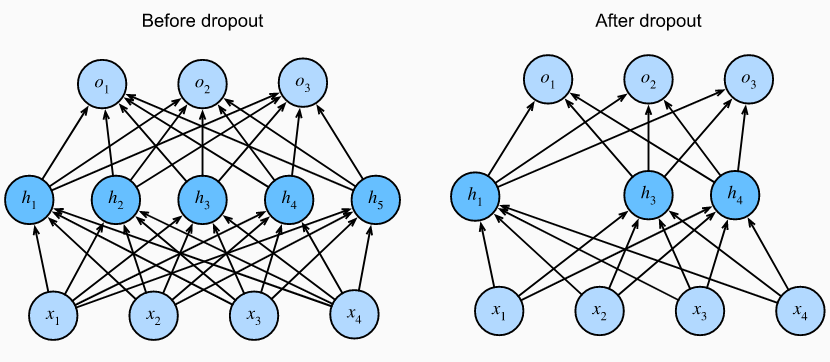

In the following code, we implement a dropout_layer function that drops out the elements in the tensor input X with probability dropout, rescaling the remainder as :


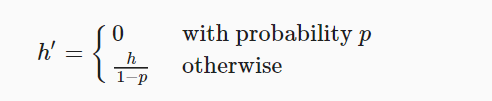

More details on : [Dropout](https://www.sciencedirect.com/science/article/pii/S0004370214000216)

In [3]:
def dropout_layer(X,dropout):
  assert 0<=dropout<=1
  if dropout == 1: #In this case all the elements are dropped out
    return torch.zeros_like(X)
  if dropout == 0:#In this case, all the elements are kept
    return X
  mask = (torch.rand(X.shape)>dropout).float() #returns 0 if less than dropout otherwise 1
  return mask*X/(1-dropout)
  

We can test out the dropout_layer function on a few_examples. In the following line of code, we pass out input X through the dropout operation, with probabilities 0,0.5 and 1 resp.

In [4]:
X = torch.arange(16,dtype = torch.float32).reshape((2,8))
print(X)
print(dropout_layer(X,0.))
print(dropout_layer(X,0.5))
print(dropout_layer(X,1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  0.,  0.,  8.,  0., 12., 14.],
        [16.,  0., 20., 22.,  0., 26., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [5]:
num_inputs,num_outputs,num_hiddens1,num_hiddens2 = 784,10,256,256

***Too Low Dropout cannot have regularization effect.
Too High Dropout may lead to Underfitting.*** 

**Implementation from scratch**

In [6]:
dropout1,dropout2 = 0.2,0.5
class Net(nn.Module):
  def __init__(self,num_inputs,num_outputs,num_hiddens1,num_hiddens2,is_training = True):
    super(Net,self).__init__()
    self.num_inputs = num_inputs
    self.training = is_training
    self.lin1 = nn.Linear(num_inputs,num_hiddens1)
    self.lin2 = nn.Linear(num_hiddens1,num_hiddens2)
    self.lin3 = nn.Linear(num_hiddens2,num_outputs)
    self.relu = nn.ReLU()

  def forward(self,X):
    H1 = self.relu(self.lin1(X.reshape((-1,self.num_inputs))))#initlializing the relu activation function for first hidden layer
    if self.training == True:
      H1=dropout_layer(H1,dropout1)#add a dropout layer after first fully connected layer
    H2 = self.relu(self.lin2(H1)) #initlializing the relu activation function for second hidden layer
    if self.training == True:
      H2= dropout_layer(H2,dropout2)#add a dropout layer after second fully connected layer
    out = self.lin3(H2) 
    return out
net = Net(num_inputs,num_outputs,num_hiddens1,num_hiddens2)

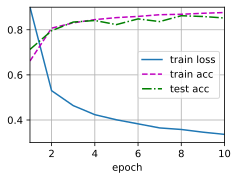

In [7]:
num_epochs,lr,batch_size = 10,0.5,256
loss = nn.CrossEntropyLoss() #initializing the loss function
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(),lr = lr) #initializing the SGD optimizer
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

**Concise Implementation**

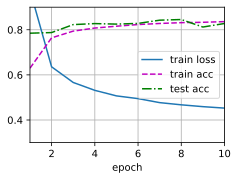

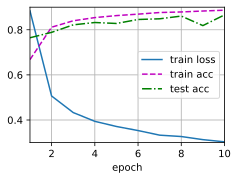

In [8]:
#Too high dropout can lead underfitting
#Too low dropout cannot have regularization effect.
for dropout1,dropout2 in [(0.7,0.5),(0.1,0.2)]:
  net = nn.Sequential(
    nn.Flatten(),nn.Linear(784,256),nn.ReLU(),
    nn.Dropout(dropout1),nn.Linear(256,256),nn.ReLU(),
    nn.Dropout(dropout2),nn.Linear(256,10)
  )
  def init_weights(m):
    if type(m) == nn.Linear:
      nn.init.normal_(m.weight,std=0.03)
  net.apply(init_weights);
  trainer = torch.optim.SGD(net.parameters(),lr=0.5)
  d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)